In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline

<b>Note:</b><br>
<ul>
    <li>How to install nltk?</li><br>
    <p>pip install nltk</p>
</ul>

nltk.download()

In [2]:
pd.set_option('display.max_colwidth', 500)

In [3]:
import os
import email
import email.policy

ham_messages_list = os.listdir('ham')
spam_messages_list = os.listdir('spam')

In [4]:
def load_email(path, filename):
    with open(os.path.join(path, filename), 'rb') as file:
        email_file = email.parser.BytesParser(policy = email.policy.default).parse(file)
    return email_file

ham_emails = [load_email('ham', filename) for filename in ham_messages_list]
spam_emails = [load_email('spam', filename) for filename in spam_messages_list]

In [5]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

In [6]:
def create_dataframes(emails, label):
    email_df = []
    for email in emails:
        try:
            if email.get_content_type() == 'text/plain' or email.get_content_type() == 'text/html' :
                l = email.get_content()
                l = cleanhtml(l)
                l = l.replace('\n',' ')
                email_df.append(l)      
        except LookupError: pass
    email_df = pd.DataFrame(email_df, columns = ['Content'])
    email_df['Label'] = label
    return email_df

ham_df = create_dataframes(ham_emails, 1)
spam_df = create_dataframes(spam_emails, 0)

<b>Concatenate both dataframes</b>

In [120]:
data = pd.concat([ham_df,spam_df], axis=0)
data = data.sample(frac=1)
data.head(2)

,Content,Label
2366,"URL: http://jeremy.zawodny.com/blog/archives/000193.html Date: 2002-09-25T22:51:45-08:00 First of all, thanks for all the great feedback. I see that a lot of folks are pulling it now. I'm working on some stats. It'll be interesting to see which stocks bloggers tend to watch, which aggregators they use,...",1
987,"URL: http://www.newsisfree.com/click/-1,8390121,1717/ Date: 2002-09-30T11:09:21+01:00 [IMG: http://www.newsisfree.com/Images/fark/yahoonews.gif ([Yahoo])]",1


<b>Checking for type text other than string is present or not.</b>

In [121]:
for i in data['Content']:
    if type(i) != str:
        print(type(i),end = ',')

<b>Change Column names</b>

In [122]:
data.columns = ['body_text', 'label']
print(data.columns)

Index(['body_text', 'label'], dtype='object')


<b>Feature Extraction</b>

<i>Body length as feature</i>

In [123]:
data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data.head(2)

,body_text,label,body_len
2366,"URL: http://jeremy.zawodny.com/blog/archives/000193.html Date: 2002-09-25T22:51:45-08:00 First of all, thanks for all the great feedback. I see that a lot of folks are pulling it now. I'm working on some stats. It'll be interesting to see which stocks bloggers tend to watch, which aggregators they use,...",1,263
987,"URL: http://www.newsisfree.com/click/-1,8390121,1717/ Date: 2002-09-30T11:09:21+01:00 [IMG: http://www.newsisfree.com/Images/fark/yahoonews.gif ([Yahoo])]",1,148


<i>Punctuation as feature</i>

In [124]:
def count_punctuation(text):
    count = sum([1 for char in text if char in string.punctuation])
    try: 
        count = round(count/(len(text) - text.count(" ")), 3)*100
    except ZeroDivisionError:
        count = round(count/(len(text)), 3)*100
    return round(count, 3)

data['punct%'] = data['body_text'].apply(lambda x: count_punctuation(x))
data.head(2)

,body_text,label,body_len,punct%
2366,"URL: http://jeremy.zawodny.com/blog/archives/000193.html Date: 2002-09-25T22:51:45-08:00 First of all, thanks for all the great feedback. I see that a lot of folks are pulling it now. I'm working on some stats. It'll be interesting to see which stocks bloggers tend to watch, which aggregators they use,...",1,263,10.6
987,"URL: http://www.newsisfree.com/click/-1,8390121,1717/ Date: 2002-09-30T11:09:21+01:00 [IMG: http://www.newsisfree.com/Images/fark/yahoonews.gif ([Yahoo])]",1,148,23.6


<b>Feature evaluation for body length</b>

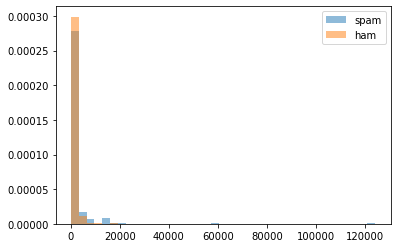

In [125]:
bins = np.linspace(0, max(data['body_len']), 40)

plt.hist(data[data["label"]==0]['body_len'], bins, alpha = 0.5, density=True, label="spam")
plt.hist(data[data["label"]==1]['body_len'], bins, alpha = 0.5, density=True, label="ham")
plt.legend(loc='upper right')
plt.show()

<li>Note: <p>From above graph a huge data points are existed between 0 to 60000.</p></li>

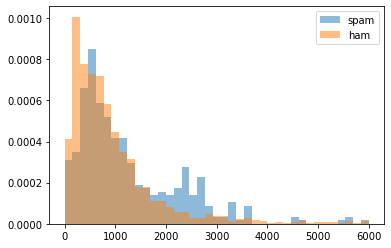

In [126]:
bins = np.linspace(0, 6000, 40)

plt.hist(data[data["label"]==0]['body_len'], bins, alpha = 0.5, density=True, label="spam")
plt.hist(data[data["label"]==1]['body_len'], bins, alpha = 0.5, density=True, label="ham")
plt.legend(loc='upper right')
plt.show()

<b>Feature evaluation for punctuation</b>

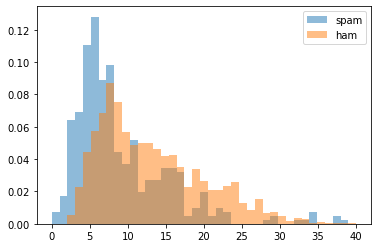

In [127]:
bins = np.linspace(0, 40, 40)

plt.hist(data[data["label"]==0]['punct%'], bins, alpha = 0.5, density=True, label="spam")
plt.hist(data[data["label"]==1]['punct%'], bins, alpha = 0.5, density=True, label="ham")
plt.legend(loc='upper right')
plt.show()

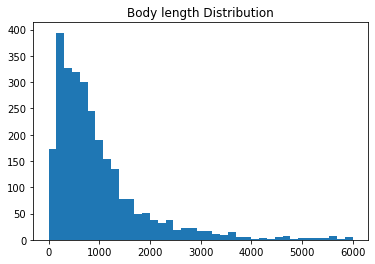

It is a left skewed data


In [128]:
bins = np.linspace(0, 6000, 40)

plt.hist(data['body_len'], bins)
plt.title("Body length Distribution")
plt.show()
print("It is a left skewed data")

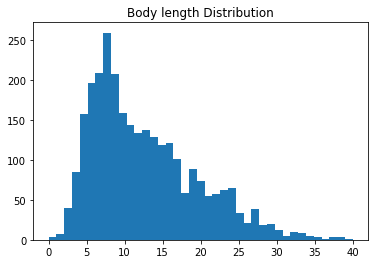

In [129]:
bins = np.linspace(0, 40, 40)

plt.hist(data['punct%'], bins)
plt.title("Body length Distribution")
plt.show()

<li>Note: <p>Our features contains huge outliers.</p></li>

<b>Transformation for features</b>

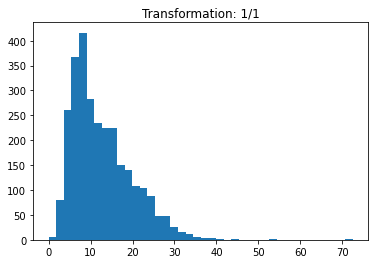

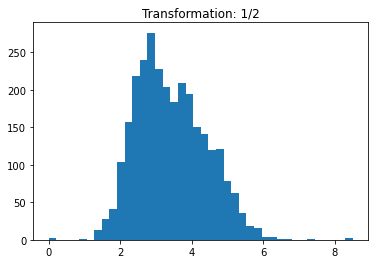

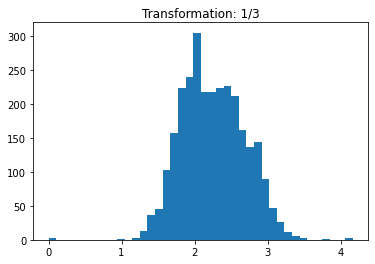

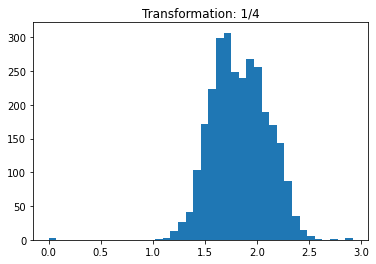

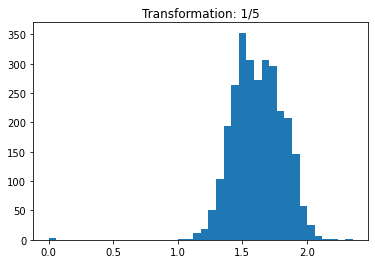

In [130]:
for i in [1, 2, 3, 4, 5]:
    plt.hist((data['punct%'])**(1/i), bins=40)
    plt.title("Transformation: 1/{}".format(str(i)))
    plt.show()

<li>Note: $y^{1/4}$ Transformation is good for Punctuation.</li>

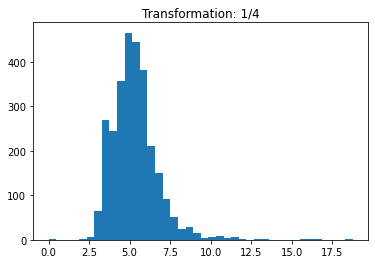

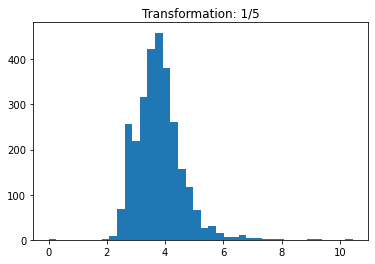

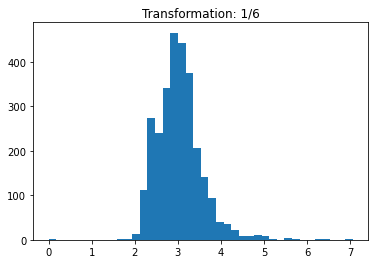

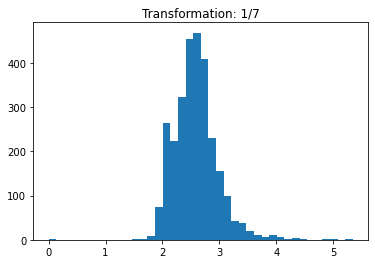

In [131]:
for i in [4, 5, 6, 7]:
    plt.hist((data['body_len'])**(1/i), bins=40)
    plt.title("Transformation: 1/{}".format(str(i)))
    plt.show()

<li>Note: $y^{1/7}$ Transformation is good for Body length.</li>

In [132]:
data['body_len'] = data['body_len'].apply(lambda x: x**(1/7))
data['punct%'] = data['punct%'].apply(lambda x: x**(1/4))
labels = data['label']

<b>Stemming and tokenization</b>

In [133]:
stop_words = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

In [134]:
def clean_text(text):
    text = "".join([word.lower() for word in text if text not in string.punctuation])
    text = re.sub(r"[^a-zA-Z0-9]+", ' ', text)
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stop_words]
    return text

<b>Vectorization</b>

In [135]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tf_vect.fit_transform(data['body_text'])

count_vect = CountVectorizer(analyzer=clean_text)
X_counts = count_vect.fit_transform(data['body_text'])

In [51]:
def vector_features(vectorizer):
    data['body_len'].reset_index(drop=True, inplace=True)
    data['punct%'].reset_index(drop=True, inplace=True)
    X_features = pd.concat([data['body_len'], data['punct%'], pd.DataFrame(vectorizer.toarray())], axis=1)
    return X_features

In [53]:
X_tfidf_features = vector_features(X_tfidf)
X_tfidf_features.head(3)

,body_len,punct%,0,1,2,3,4,5,6,7,...,29376,29377,29378,29379,29380,29381,29382,29383,29384,29385
0,2.209409,1.800103,0.055356,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.481849,1.608862,0.023694,0.032145,0.030531,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.573205,1.584292,0.037733,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
X_count_features = vector_features(X_tfidf)
X_count_features.head(3)

,body_len,punct%,0,1,2,3,4,5,6,7,...,29376,29377,29378,29379,29380,29381,29382,29383,29384,29385
0,2.209409,1.800103,0.055356,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.481849,1.608862,0.023694,0.032145,0.030531,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.573205,1.584292,0.037733,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<b>Split dataset into train, test, validation</b>

In [55]:
from sklearn.model_selection import train_test_split

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tfidf_features, data['label'], test_size = 0.2, random_state = 42)
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(X_count_features, data['label'], test_size = 0.2, random_state = 42)

In [56]:
print("X_train data: ", X_train_tf.shape)
print("X_test data: ", X_test_tf.shape)

X_train data:  (2282, 29388)
X_test data:  (571, 29388)


<b>Random Forest Classification</b>

In [57]:
from sklearn.ensemble import RandomForestClassifier

print(dir(RandomForestClassifier()))

['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_check_n_features', '_estimator_type', '_get_param_names', '_get_tags', '_make_estimator', '_more_tags', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_required_parameters', '_set_oob_score', '_validate_X_predict', '_validate_data', '_validate_estimator', '_validate_y_class_weight', 'apply', 'base_estimator', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'decision_path', 'estimator_params', 'feature_importances_', 'fit', 'get_params', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_imp

<b>Exploring random forest classifier through Cross-Validation</b>

In [58]:
from sklearn.model_selection import KFold, cross_val_score

rf = RandomForestClassifier(n_jobs=-1)
k_fold = KFold(n_splits = 5, n_jobs=-1)
cross_val_score(rf, X_tfidf_features, data['label'], cv=k_fold)

array([0.96672504, 0.97197898, 0.9737303 , 0.96842105, 0.96666667])

In [59]:
rf = RandomForestClassifier(n_jobs=-1)
k_fold = KFold(n_splits = 5, n_jobs=-1)
cross_val_score(rf, X_count_features, data['label'], cv=k_fold)

array([0.9737303 , 0.9737303 , 0.9737303 , 0.96666667, 0.95789474])

<b>Exploring random forest classifier with Hold-out set (Train, Test)</b>

In [60]:
rf = RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1)
rf_model_tf = rf.fit(X_train_tf, y_train_tf)

<b>Exploring Feature importance given by model after training</b>

In [61]:
sorted(zip(rf_model_tf.feature_importances_, X_tfidf_features.columns), reverse=True)[:10]

[(0.01498542648513759, 20993),
 (0.014756020792772067, 22559),
 (0.014093421257185235, 19715),
 (0.014064935823676215, 12837),
 (0.014033759311221914, 27733),
 (0.008526882067379254, 9037),
 (0.008475538499612053, 13772),
 (0.00799430074805336, 'punct%'),
 (0.007701348832169136, 1847),
 (0.00731471002185174, 9296)]

In [62]:
rf = RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1)
rf_model_count = rf.fit(X_train_count, y_train_count)

In [63]:
sorted(zip(rf_model_count.feature_importances_, X_count_features.columns), reverse=True)[:10]

[(0.02448675857199041, 19910),
 (0.020257651197281686, 22559),
 (0.016945030846619195, 18973),
 (0.015324894974452743, 12837),
 (0.013051526285028488, 28436),
 (0.01110253729940127, 20993),
 (0.01103515160143115, 8850),
 (0.008263847007729015, 19940),
 (0.007964582061844114, 9296),
 (0.007962894382079932, 27733)]

<b>Metrics</b>

In [64]:
from sklearn.metrics import precision_recall_fscore_support as score

y_pred_tf = rf_model_tf.predict(X_test_tf)
precision, recall, fscore, support = score(y_test_tf, y_pred_tf, pos_label=0, average='binary')

print("Precision: {} / Recall: {} / Accuracy: {}".format(round(precision ,3),
                                                         round(recall, 3),
                                                         round((y_pred_tf == y_test_tf).sum()/len(y_pred_tf),3)))

Precision: 1.0 / Recall: 0.571 / Accuracy: 0.932


In [65]:
y_pred_count = rf_model_count.predict(X_test_count)
precision, recall, fscore, support = score(y_test_count, y_pred_count, pos_label=0, average='binary')

print("Precision: {} / Recall: {} / Accuracy: {}".format(round(precision ,3),
                                                         round(recall, 3),
                                                         round((y_pred_count == y_test_count).sum()/len(y_pred_count),3)))

Precision: 1.0 / Recall: 0.593 / Accuracy: 0.935


<b>Tuning Hyper parameters using Grid Sreach CV</b>

<li>Self made Grid Search CV</li>

In [66]:
def train_RF(n_est, depth, X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, n_jobs=-1)
    rf_model = rf.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    precision, recall, fscore, support = score(y_test, y_pred, pos_label=0, average='binary')

    print("Est: {} / Depth: {} / ------- Precision: {} / Recall: {} / Accuracy: {}".format(n_est, depth, round(precision ,3),
                                                         round(recall, 3),
                                                         round((y_pred == y_test).sum()/len(y_pred),3)))

In [67]:
for n_est in [10, 50, 100]:
    for depth in [10, 20, 30 , None]:
        train_RF(n_est, depth, X_train_tf, X_test_tf, y_train_tf, y_test_tf)

Est: 10 / Depth: 10 / ------- Precision: 1.0 / Recall: 0.352 / Accuracy: 0.897
Est: 10 / Depth: 20 / ------- Precision: 1.0 / Recall: 0.56 / Accuracy: 0.93
Est: 10 / Depth: 30 / ------- Precision: 0.966 / Recall: 0.626 / Accuracy: 0.937
Est: 10 / Depth: None / ------- Precision: 1.0 / Recall: 0.714 / Accuracy: 0.954
Est: 50 / Depth: 10 / ------- Precision: 1.0 / Recall: 0.341 / Accuracy: 0.895
Est: 50 / Depth: 20 / ------- Precision: 1.0 / Recall: 0.582 / Accuracy: 0.933
Est: 50 / Depth: 30 / ------- Precision: 1.0 / Recall: 0.615 / Accuracy: 0.939
Est: 50 / Depth: None / ------- Precision: 1.0 / Recall: 0.714 / Accuracy: 0.954
Est: 100 / Depth: 10 / ------- Precision: 1.0 / Recall: 0.286 / Accuracy: 0.886
Est: 100 / Depth: 20 / ------- Precision: 1.0 / Recall: 0.593 / Accuracy: 0.935
Est: 100 / Depth: 30 / ------- Precision: 1.0 / Recall: 0.626 / Accuracy: 0.94
Est: 100 / Depth: None / ------- Precision: 1.0 / Recall: 0.703 / Accuracy: 0.953


In [68]:
for n_est in [10, 50, 100]:
    for depth in [10, 20, 30 , None]:
        train_RF(n_est, depth, X_train_count, X_test_count, y_train_count, y_test_count)

Est: 10 / Depth: 10 / ------- Precision: 1.0 / Recall: 0.385 / Accuracy: 0.902
Est: 10 / Depth: 20 / ------- Precision: 0.98 / Recall: 0.538 / Accuracy: 0.925
Est: 10 / Depth: 30 / ------- Precision: 0.983 / Recall: 0.648 / Accuracy: 0.942
Est: 10 / Depth: None / ------- Precision: 0.986 / Recall: 0.769 / Accuracy: 0.961
Est: 50 / Depth: 10 / ------- Precision: 1.0 / Recall: 0.363 / Accuracy: 0.898
Est: 50 / Depth: 20 / ------- Precision: 1.0 / Recall: 0.582 / Accuracy: 0.933
Est: 50 / Depth: 30 / ------- Precision: 1.0 / Recall: 0.615 / Accuracy: 0.939
Est: 50 / Depth: None / ------- Precision: 1.0 / Recall: 0.692 / Accuracy: 0.951
Est: 100 / Depth: 10 / ------- Precision: 1.0 / Recall: 0.33 / Accuracy: 0.893
Est: 100 / Depth: 20 / ------- Precision: 1.0 / Recall: 0.571 / Accuracy: 0.932
Est: 100 / Depth: 30 / ------- Precision: 1.0 / Recall: 0.626 / Accuracy: 0.94
Est: 100 / Depth: None / ------- Precision: 1.0 / Recall: 0.703 / Accuracy: 0.953


In [70]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print("Confusion Marix")
print(confusion_matrix(y_test_count, y_pred_count))
print("\nClassification report:")
report = classification_report(y_test_count, y_pred_count, target_names=['spam', 'ham'])
print(report)

Confusion Marix
[[ 54  37]
 [  0 480]]

Classification report:
              precision    recall  f1-score   support

        spam       1.00      0.59      0.74        91
         ham       0.93      1.00      0.96       480

    accuracy                           0.94       571
   macro avg       0.96      0.80      0.85       571
weighted avg       0.94      0.94      0.93       571



In [71]:
print("Cconfusion Marix")
print(confusion_matrix(y_test_tf, y_pred_tf))
print("\nClassification report:")
report = classification_report(y_test_tf, y_pred_tf, target_names=['spam', 'ham'])
print(report)

Cconfusion Marix
[[ 52  39]
 [  0 480]]

Classification report:
              precision    recall  f1-score   support

        spam       1.00      0.57      0.73        91
         ham       0.92      1.00      0.96       480

    accuracy                           0.93       571
   macro avg       0.96      0.79      0.84       571
weighted avg       0.94      0.93      0.92       571



<b>Naive Bayes Algorithm</b>

In [90]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

print(dir(GaussianNB()))

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_check_X', '_check_n_features', '_estimator_type', '_get_param_names', '_get_tags', '_joint_log_likelihood', '_more_tags', '_partial_fit', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_update_mean_variance', '_validate_data', 'fit', 'get_params', 'partial_fit', 'predict', 'predict_log_proba', 'predict_proba', 'priors', 'score', 'set_params', 'var_smoothing']


In [93]:
nb = GaussianNB()
nb_model = nb.fit(X_train_tf, y_train_tf)

In [94]:
y_pred_tf = nb_model.predict(X_test_tf)
print("Confusion matrix: \n", confusion_matrix(y_test_tf, y_pred_tf))
report = classification_report(y_test_tf, y_pred_tf, target_names=["spam", "ham"])
print("Classification report: \n",report)

Confusion matrix: 
 [[ 67  24]
 [  5 475]]
Classification report: 
               precision    recall  f1-score   support

        spam       0.93      0.74      0.82        91
         ham       0.95      0.99      0.97       480

    accuracy                           0.95       571
   macro avg       0.94      0.86      0.90       571
weighted avg       0.95      0.95      0.95       571



In [100]:
print("Precision: {} / Recall: {} / Accuracy: {}".format(round(precision ,3),
                                                         round(recall, 3),
                                                         round((y_pred_tf == y_test_tf).sum()/len(y_pred_tf),3)))

Precision: 1.0 / Recall: 0.593 / Accuracy: 0.928


<b>Support Vector Machine</b>

In [92]:
from sklearn.svm import SVC

print(dir(SVC()))
svm_classifier = SVC()
svc_model = svm_classifier.fit(X_train_tf, y_train_tf)

In [98]:
y_pred_tf = svc_model.predict(X_test_tf)
print("Confusion matrix:\n", confusion_matrix(y_pred_tf, y_test_tf))
print("Classification report:\n", classification_report(y_pred_tf, y_test_tf, target_names = ["spam", "ham"]))

Confusion matrix:
 [[ 50   0]
 [ 41 480]]
Classification report:
               precision    recall  f1-score   support

        spam       0.55      1.00      0.71        50
         ham       1.00      0.92      0.96       521

    accuracy                           0.93       571
   macro avg       0.77      0.96      0.83       571
weighted avg       0.96      0.93      0.94       571



In [99]:
print("Precision: {} / Recall: {} / Accuracy: {}".format(round(precision ,3),
                                                         round(recall, 3),
                                                         round((y_pred_tf == y_test_tf).sum()/len(y_pred_tf),3)))

Precision: 1.0 / Recall: 0.593 / Accuracy: 0.928


<b>Real time Predictions</b>

In [101]:
with open("sample.txt", "r") as file:
    message = file.read()

In [107]:
message_clean_html = cleanhtml(message)
l = message_clean_html.replace('\n',' ')
punct_percent = count_punctuation(l)
s = re.sub(r"[^a-zA-Z0-9]+", ' ', l)
s = s.lower()
data_length = len(s) - s.count(" ")
print("Data length: {} / Punctuation %: {}".format(data_length, punct_percent))

Data length: 297 / Punctuation %: 4.1


In [114]:
message_data = pd.DataFrame({"body_text": [s]})
message_data["punct%"] = punct_percent
message_data["body_len"] = data_length
message_data

,body_text,punct%,body_len
0,disney hotstar unsubscribe thu jan 14 10 50 pm to me don t miss jayam ravi s action packed drama as he embarks on a journey to get back to his roots disney hotstar vip and premium subscribers can watch multiplex movies at no additional cost get on mobile watch on tv got questions email us at vip hotstar com 2021 disney and its related entities click here to optout,4.1,297


In [136]:
test = tf_vect.transform(message_data['body_text'])
test_features = pd.concat([message_data['body_len'], message_data['punct%'], pd.DataFrame(test.toarray())], axis=1)

In [137]:
test_features

,body_len,punct%,0,1,2,3,4,5,6,7,...,29376,29377,29378,29379,29380,29381,29382,29383,29384,29385
0,297,4.1,0.026148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
if rf_model_tf.predict(test_features) == 0:
    print("Spam")
else:
    print("Ham")

Ham
